In [209]:
# 1 - DATA MANIPULATION
import pandas as pd
import numpy as np

# 2 - DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - DATA EXPLORATION
from ydata_profiling import ProfileReport

# 4 - FEATURE ENGINEERING AND PREPROCESSING
import string #punctuation
import textstat

import nltk #English language stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm

import spacy
nlp = spacy.load("en_core_web_sm")

from lexicalrichness import LexicalRichness

import re

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.regularizers import l1, l2, l1_l2


# 5 - MODEL
#SKLEARN METRICS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


In [210]:
import tensorflow as tf
print(tf.test.gpu_device_name())


/device:GPU:0


2023-12-12 15:05:37.369739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 15:05:37.370003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [211]:
# Check tensorflow metal:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [212]:
# gpu is slower for this challenge
# Disable GPUs:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [213]:
df = pd.read_csv('/Users/andreacalcagni/code/AndreaCalcagni/neuroCraft/raw_data/CLEAR Corpus 6.01 - CLEAR Corpus 6.01.csv')


In [214]:
df = df.drop(columns=['Last Changed', 'URL', 'Anthology', 'MPAA \n#Max', 'Pub Year', 'MPAA\n#Avg', 'License', 'British Words', 'firstPlace_pred', 'secondPlace_pred', 'thirdPlace_pred',
       'fourthPlace_pred', 'fifthPlace_pred', 'sixthPlace_pred', 'ID', 'Author', 'Title', 'Source', 'Category', 'Location', 'MPAA\nMax', 'BT s.e.', 'Kaggle split'])


# 1. Feature Engineering

## 1.1 Text-Based Features

### 1.1.1. Word Count

In [215]:
def avg_word_count(row):
    return row[['Joon\nWC v1', 'Google\nWC']].mean()

# Create a new column
df['Avg Word Count'] = df.apply(avg_word_count, axis=1)
df = df.drop(columns=['Joon\nWC v1', 'Google\nWC'])


### 1.1.2 Unique Word Count

In [216]:
def count_unique_words(row):
    words = row['Excerpt'].split()
    return len(set(words))

df['Unique Word Count'] = df.apply(count_unique_words, axis=1)


### 1.1.3 Word Lenght

In [217]:
def avg_word_length(x):
    punctuation = string.punctuation
    for punc in punctuation:
        x = x.replace(punc,' ')
    words = x.split(' ')
    words = [word for word in words if len(word) > 0]
    word_len = [len(word) for word in words]
    return np.mean(word_len)

# New column 'Avg Word Length'
df['Avg Word Length'] = df['Excerpt'].apply(avg_word_length)


### 1.1.4 Sentence Count

In [218]:
def calculate_average_sentence_count(row):
    sentence_count_columns = ['Sentence\nCount v1', 'Sentence\nCount v2']
    return row[sentence_count_columns].mean()

# new column
df['Average Sentence Count'] = df.apply(calculate_average_sentence_count, axis=1)
df= df.drop(columns=['Sentence\nCount v1', 'Sentence\nCount v2'])


## 1.2 Complexity Features

### 1.2.1 Average Syllaba per Word

In [219]:
def avg_syllaba_word(x):
    syll_count = [textstat.syllable_count(word) for word in x.split()]
    return np.mean(syll_count)

df['Avg Syllables Per Word'] = df['Excerpt'].apply(avg_syllaba_word)


### 1.2.2 Avg Vowels per Word

In [220]:
def count_vowels(word):
    vowels = set("AEIOUaeiou")
    return sum(1 for char in word if char in vowels)

# New columns:
df['Avg Vowel Count Per Word'] = df['Excerpt'].apply(lambda x: np.mean([count_vowels(word) for word in x.split()]) if x else 0)
df['Total Vowels Per Excerpt'] = df['Excerpt'].apply(lambda x: sum(count_vowels(word) for word in x.split()) if x else 0)
df['Avg Vowels Per Excerpt'] = df['Total Vowels Per Excerpt']/df['Avg Word Count']
df = df.drop(columns=['Total Vowels Per Excerpt'])


### 1.2.3 Punctuation Ratio

In [221]:
def count_punctuation(x):
    punc = string.punctuation
    count=0

    for char in x:
        if char in punc:
            count+=1

    return count/ len(x)

df['punctuation_ratio'] = df['Excerpt'].apply(count_punctuation)


## 1.3 Structural Features

### 1.3.1 Average Sentence Lenght

In [222]:
def count_characters_per_sentence(excerpt):
    # Tokenize the text into sentences
    sentences = sent_tokenize(excerpt)

    # Count the number of characters in each sentence
    char_counts_per_sentence = [len(sentence) for sentence in sentences]

    return char_counts_per_sentence

df['Characters Per Sentence'] = df['Excerpt'].apply(count_characters_per_sentence)

def avg_chars_per_sentence(row):
    # Sum of character counts in all sentences
    total_chars = sum(row['Characters Per Sentence'])

    # Sum of sentence counts from both columns
    total_sentences = row['Average Sentence Count']

    # Calculate average characters per sentence
    return total_chars / total_sentences if total_sentences > 0 else 0

df['Avg Characters per Sentence'] = df.apply(avg_chars_per_sentence, axis=1)
df = df.drop(columns=['Characters Per Sentence'])


### 1.3.2 Ratio of Capital Letters

In [223]:
def ratio_capital_chars(excerpt):
    count = 0
    for char in excerpt:
        if char.isupper():
            count += 1
    return count/len(excerpt)

# new column
df['Capital Char Count'] = df['Excerpt'].apply(ratio_capital_chars)


In [224]:
def count_capital_words(excerpt):
    return sum(1 for word in excerpt.split() if word.isupper() and word.isalpha())

# new column
df['Capital Word Count'] = df['Excerpt'].apply(count_capital_words)
df['Ratio_capital_words'] = df['Capital Word Count']/df['Avg Word Count']
df = df.drop(columns=['Capital Word Count'])


## 1.4 Statistical Features

### 1.4.1 Std of Word Lenght

In [225]:
def word_length_std(excerpt):
    word_lengths = [len(word) for word in excerpt.split()]
    return np.std(word_lengths) if len(word_lengths) > 0 else 0

# New column 'Word Length Std'
df['Word Length Std'] = df['Excerpt'].apply(word_length_std)


### 1.4.2 Std of Sentence Lenght

In [226]:
def sentence_length_variation(row):
    sentence_lengths = count_characters_per_sentence(row['Excerpt'])
    return np.std(sentence_lengths)

df['Sentence Length Variation'] = df.apply(sentence_length_variation, axis=1)


## 1.5 Syntactic Complexity Features (NLP approach)

### 1.5.1 Avg sentence len in words

In [227]:
def sentence_len(x):

    x = x.replace("?",'.').replace("!",'.')

    sentences = x.split('.')

    sentences = [sentence for sentence in sentences if len(sentence) > 0]

    sent_len = [len(sentence.split()) for sentence in sentences]

    return np.mean(sent_len)

df['avg_sentence_len_words'] = df['Excerpt'].apply(sentence_len)


### 1.5.2 Number of clauses per sentence

In [228]:
# Function to calculate the number of clauses per sentence

# # Function to perform POS tagging and count occurrences of each POS
# def pos_distribution(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the occurrences of each POS
#     pos_counts = Counter(token.pos_ for token in doc)
#     return pos_counts


# # Apply functions to create new columns
# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)

# df['POS Distribution'] = df['Excerpt'].apply(pos_distribution)


In [229]:
# Function to calculate the number of clauses per sentence
# def num_clauses_per_sentence_nlp(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the number of clauses (sentences) in the parsed document
#     num_clauses = len(list(doc.sents))
#     return num_clauses

# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)


## 1.6 Lexical Diversity

In [230]:
def add_lexical_richness_features(df):
    cttr_list, msttr_list, mtld_list, yule_k_list = [], [], [], []

    for text in df['Excerpt']:
        lex = LexicalRichness(text)
        cttr_list.append(lex.cttr)
        msttr_list.append(lex.msttr(segment_window=25))  # Adjust the segment_window as needed
        mtld_list.append(lex.mtld(threshold=0.72))  # Adjust the threshold as needed
        yule_k_list.append(lex.yulek)

    df['cttr'] = cttr_list
    df['msttr'] = msttr_list
    df['mtld'] = mtld_list
    df['yule_k'] = yule_k_list

# Add lexical richness features to the DataFrame
add_lexical_richness_features(df)


In [231]:
# lexical_columns = ['cttr', 'msttr', 'mtld', 'yule_k']

# # new DataFrame with only the selected columns
# lexical_df = df[lexical_columns]

# # Calculate the correlation matrix
# correlation_matrix = lexical_df.corr()

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title("Correlation Matrix of Lexical Richness Features")
# plt.show()


In [232]:
df = df.drop(columns=['mtld', 'Avg Syllables Per Word', 'CARES',
       'avg_sentence_len_words', 'msttr', 'Avg Vowels Per Excerpt',
       'Paragraphs', 'Automated Readability Index',
       'Avg Vowel Count Per Word', 'Flesch-Reading-Ease',
       'Flesch-Kincaid-Grade-Level', 'British WC', 'SMOG Readability',
       'Average Sentence Count', 'CAREC'])


# 2. Discretizing Target

In [233]:
# Calculating quantiles for bin edges - 7 edges for 6 bins
# quantiles = df['BT Easiness'].quantile([0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1]).tolist()

quantiles = df['BT Easiness'].quantile([0, 0.3333, 0.6667, 1]).tolist()


In [234]:
# Correct number of labels for 6 bins
labels_dict = {'hard':0, 'acceptable':1, 'easy':2}

# Using 'quantiles' for bins and including 6 labels
df['BT Easiness'] = pd.cut(
    x=df['BT Easiness'],
    bins=quantiles,
    labels=labels_dict.values(),
    include_lowest=True
)


# 3. Train Test Split

In [235]:
X = df.drop(columns=['BT Easiness'])
y = df['BT Easiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. Dummy Baseline Model

In [236]:
y_pred = y_train.value_counts().idxmax()
y_pred = np.full(y_test.shape, y_pred)

accuracy_baseline = accuracy_score(y_test, y_pred)
accuracy_baseline


0.3164021164021164

# 5. NLP Model

## 5.1 Text Preprocessing

In [237]:
X_train_text = X_train['Excerpt'].values
X_test_text = X_test['Excerpt'].values


### 5.1.1 Basic Cleaning

In [238]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Adding special quotes to the regular expression pattern
    special_quotes = '“”‘’'
    pattern = '[' + re.escape(string.punctuation + special_quotes) + ']'

    sentence = re.sub(pattern, '', sentence)
    sentence = sentence.strip()

    return sentence


In [239]:
X_train_text = [basic_cleaning(sentence) for sentence in X_train_text]
X_test_text = [basic_cleaning(sentence) for sentence in X_test_text]


### 5.1.2 Tokenizing

In [240]:
# def tokenizer(sentence):
#     return text_to_word_sequence(sentence)


In [241]:
# #tokenizing
# X_train_text = [tokenizer(sentence) for sentence in X_train_text]
# X_test_text = [tokenizer(sentence) for sentence in X_test_text]


### 5.1.3 Lemmatizing

In [242]:
# def lemmatizer(sentence):
#     wnl = WordNetLemmatizer()
#     verbs_lemmatized = []
#     for word in sentence:
#         verbs_lemmatized.append(wnl.lemmatize(word, pos = 'v'))
#     nouns_lemmatized = []
#     for word in verbs_lemmatized:
#         nouns_lemmatized.append(wnl.lemmatize(word, pos = 'n'))
#     adverbs_lemmatized = []
#     for word in nouns_lemmatized:
#         adverbs_lemmatized.append(wnl.lemmatize(word, pos = 'r'))
#     adj_lemmatized = []
#     for word in adverbs_lemmatized:
#         adj_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     sat_lemmatized = []
#     for word in adj_lemmatized:
#         sat_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     return sat_lemmatized


In [243]:
# X_train_text = [lemmatizer(sentence) for sentence in X_train_text]
# X_test_text = [lemmatizer(sentence) for sentence in X_test_text]


### 5.1.4 Removing Stopwords

In [244]:
# def removing_stopwords(sentence):
#     stop_words = set(stopwords.words('english'))
#     sentence_new = [w for w in sentence if not w in stop_words]
#     return sentence_new

# X_train_text = [removing_stopwords(sentence) for sentence in X_train_text]
# X_test_text = [removing_stopwords(sentence) for sentence in X_test_text]


### 5.1.5 Creating Embeddings

In [245]:
def create_embeddings(excerpts, model_name="roberta-base", max_length=190):
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")
    model = TFAutoModel.from_pretrained(model_name, from_pt=True)

    # Tokenize all excerpts at once
    tokenized_excerpts = tokenizer(excerpts, max_length=max_length, padding="max_length", truncation=True, return_tensors="tf")

    # Generate embeddings in a batch
    embeddings = model.predict(tokenized_excerpts["input_ids"])

    return embeddings.last_hidden_state#[:,0,:]

# Assuming X_train_text and X_test_text are lists of sentences/excerpts
with tf.device('GPU:0'):  # Change to '/CPU:0' if you want to use CPU
    X_train_text = create_embeddings(X_train_text)
    X_test_text = create_embeddings(X_test_text)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


119/119 [==============================] - 356s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


30/30 [==============================] - 92s 3s/step


In [246]:
X_train_text.shape


(3779, 190, 768)

## 5.2 Model Training

In [247]:
# def build_model_nlp():
#     model = Sequential([
#         # layers.Conv1D(105, kernel_size=15, padding='same', activation="relu", input_shape=X_train_pad.shape[1:]),
#         # layers.Conv1D(64, kernel_size=10, padding='same', activation="relu"),
#         # layers.Flatten(),
#         #layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=X_train_text.shape[1:]),
#         #layers.Bidirectional(layers.LSTM(64), input_shape=(512,)),
#         #layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(512,)),
#         layers.Bidirectional(layers.LSTM(64, kernel_constraint=MaxNorm(3)), input_shape=X_train_text.shape[1:]),
#         layers.Dropout(0.3),
#         layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#         layers.Dropout(0.3),
#         layers.Dense(4, activation='softmax'),
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
#     return model

# model_nlp = build_model_nlp()
# model_nlp.summary()


In [248]:
# es = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# model_nlp = build_model_nlp()
# with tf.device('GPU:0'):
#     model_nlp.fit(X_train_text, y_train,
#             validation_split=0.3,
#             epochs=50,
#             batch_size=32,
#             callbacks=[es, reduce_lr]
#             )


In [249]:
def build_model_nlp(compile=False, combine=True):
    input_nlp = layers.Input(shape=X_train_text.shape[1:])
    x = layers.Bidirectional(layers.LSTM(32, kernel_constraint=MaxNorm(3), return_sequences=True, kernel_regularizer=l2(0.01)))(input_nlp)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.LSTM(16, kernel_constraint=MaxNorm(3), kernel_regularizer=l2(0.01)))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = layers.Dropout(0.5)(x)

    output_nlp = layers.Dense(16, activation="relu")(x)

    if combine==False:
        output_nlp = layers.Dense(3, activation="softmax")(output_nlp)


    model_nlp = models.Model(inputs=input_nlp, outputs=output_nlp)

    if compile:
        model_nlp.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model_nlp

model_nlp = build_model_nlp(compile=True, combine=False)
model_nlp.summary()


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 190, 768)]        0         
                                                                 
 bidirectional_25 (Bidirect  (None, 190, 64)           205056    
 ional)                                                          
                                                                 
 dropout_270 (Dropout)       (None, 190, 64)           0         
                                                                 
 bidirectional_26 (Bidirect  (None, 32)                10368     
 ional)                                                          
                                                                 
 dropout_271 (Dropout)       (None, 32)                0         
                                                                 
 dense_72 (Dense)            (None, 16)                528

In [250]:
# def build_model_nlp():
#     model = Sequential([
#         layers.Bidirectional(layers.LSTM(32, kernel_constraint=MaxNorm(3), return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=X_train_text.shape[1:]),
#         layers.Dropout(0.5),
#         layers.Bidirectional(LSTM(16, kernel_regularizer=l2(0.01))),
#         layers.Dropout(0.4),
#         layers.Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
#         layers.Dropout(0.5),
#         layers.Dense(3, activation='softmax')
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#     return model

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks
es = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(scheduler)


model_nlp = build_model_nlp(compile=True, combine=False)
model_nlp.summary()

# Fit the model
with tf.device('GPU:0'):
    history = model_nlp.fit(
        X_train_text, y_train,
        validation_split=0.3,
        epochs=50,
        batch_size=32,
        callbacks=[es, reduce_lr, lr_scheduler]
    )


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 190, 768)]        0         
                                                                 
 bidirectional_27 (Bidirect  (None, 190, 64)           205056    
 ional)                                                          
                                                                 
 dropout_273 (Dropout)       (None, 190, 64)           0         
                                                                 
 bidirectional_28 (Bidirect  (None, 32)                10368     
 ional)                                                          
                                                                 
 dropout_274 (Dropout)       (None, 32)                0         
                                                                 
 dense_75 (Dense)            (None, 16)                528

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


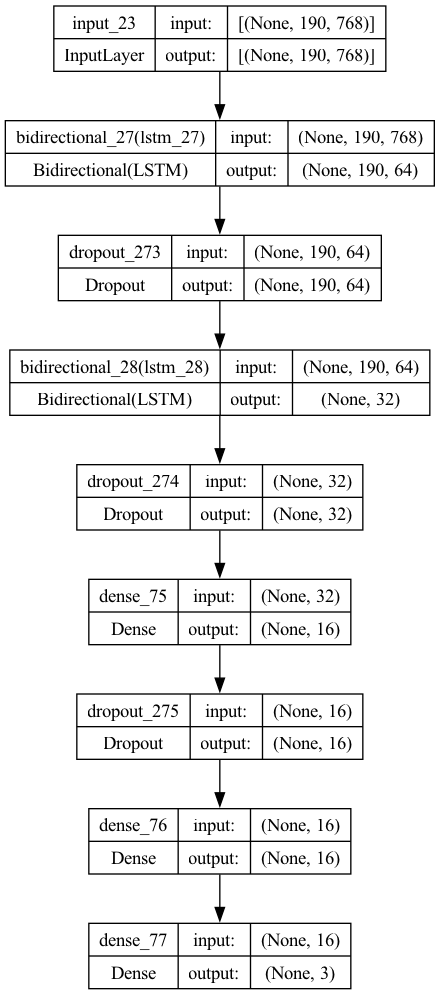

In [251]:
import tensorflow as tf
tf.keras.utils.plot_model(model_nlp, "nlp_model.png", show_shapes=True)


## 5.3 Model Evaluation

In [252]:
def plot_history(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=4)
    ax2.set_ylim(ymin=0, ymax=1)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    plt.show()


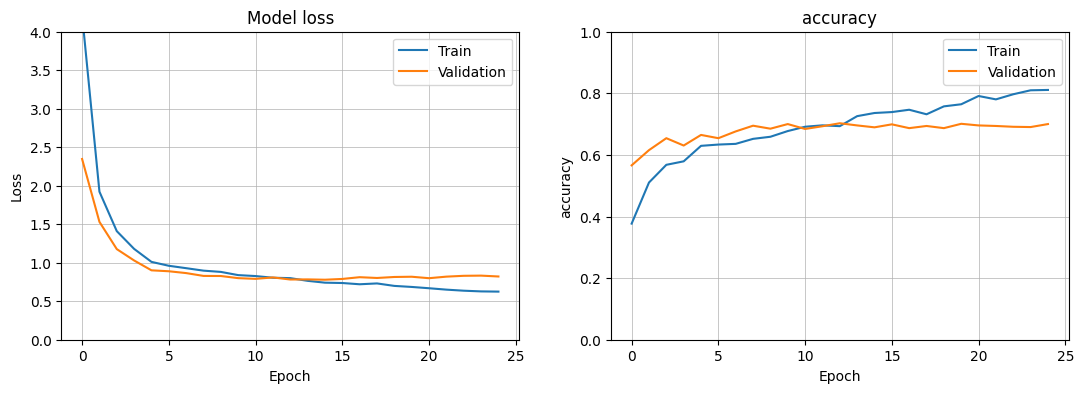

In [253]:
plot_history(history)


In [254]:
loss, accuracy = model_nlp.evaluate(X_test_text, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 45ms/step - loss: 0.7600 - accuracy: 0.6963
Test loss: 0.7600
Test accuracy: 0.6963


In [255]:
predictions = model_nlp.predict(X_test_text)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 2s 44ms/step


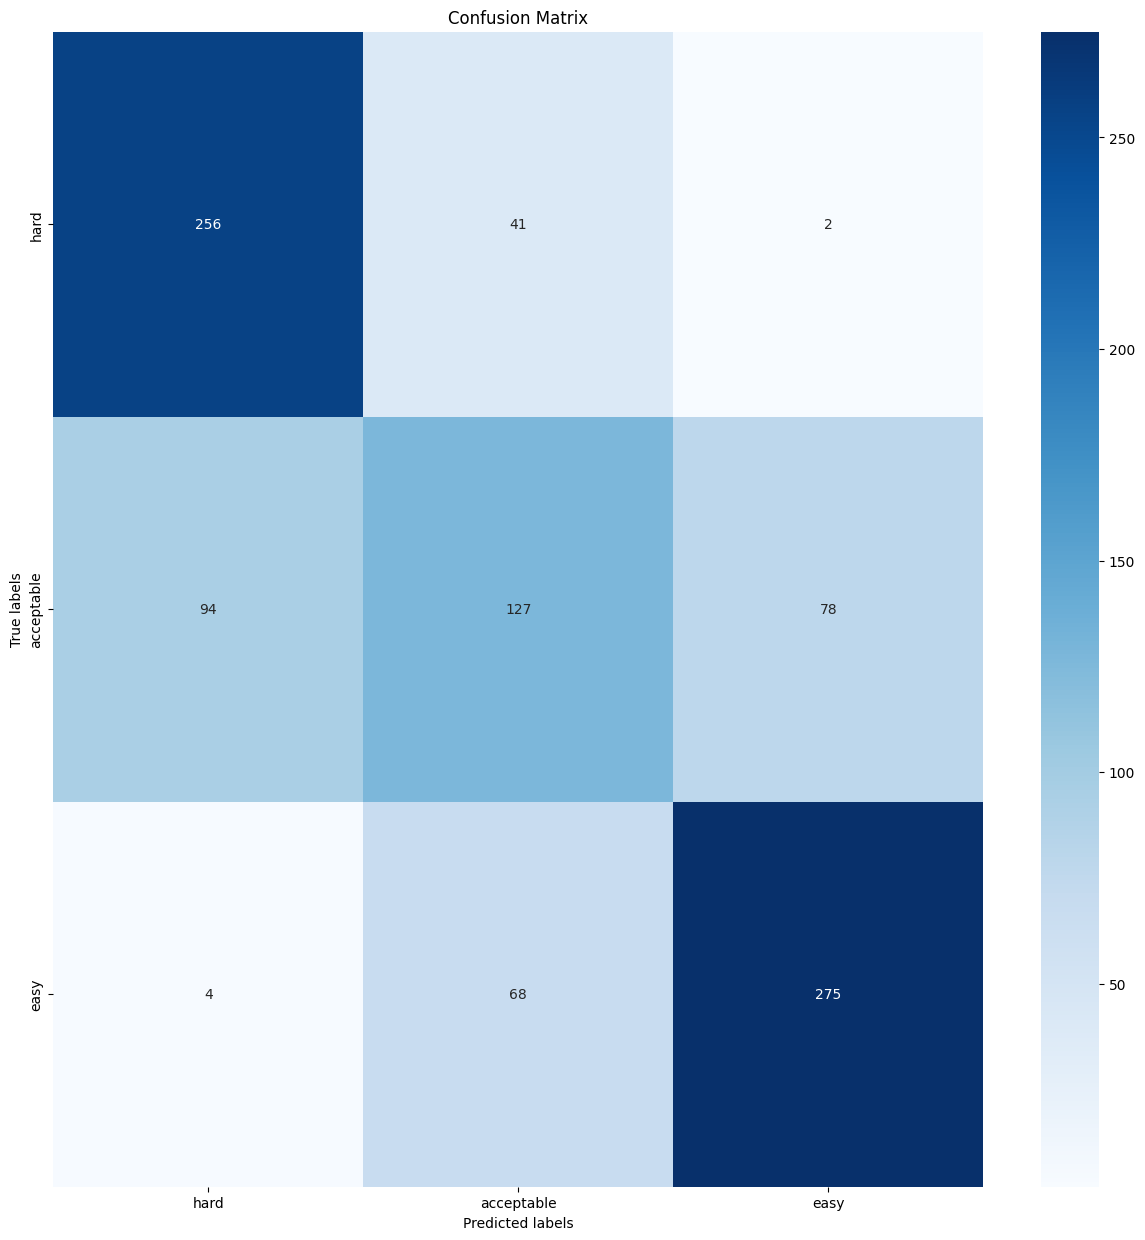

In [256]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


In [257]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.86      0.78       299
           1       0.54      0.42      0.47       299
           2       0.77      0.79      0.78       347

    accuracy                           0.70       945
   macro avg       0.68      0.69      0.68       945
weighted avg       0.68      0.70      0.69       945



In [258]:
# df['Excerpt'].iloc[3]


In [259]:
# simplified = "Mr. Grimes was going to Sir John Harthover's place the next morning to sweep the chimneys because their usual chimney sweep was in jail. He left quickly, so Tom couldn't ask why the sweep was in jail, which interested Tom since he had been in jail a few times too. Tom saw the groom, who looked very neat and clean in his drab clothes and white tie with a fancy pin, and had a round, red face. Tom felt jealous and thought the groom was showing off just because he wore nice clothes paid for by others. Tom wanted to throw a brick at him, but he didn't because he was there for work, which was like being in a truce."


In [260]:
# simplified_embedding = create_embeddings(simplified)


In [261]:
# predicted_text = model_nlp.predict(simplified_embedding)

# # Convert probabilities to class labels
# predicted_text = np.argmax(predicted_text, axis=1)
# predicted_text


# 6. Model with numerical features

In [262]:
X_train_num = X_train.drop(columns=['Excerpt'])
X_test_num = X_test.drop(columns=['Excerpt'])


## 6.1 Preprocessing

### 6.1.1 Scaling

In [263]:
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


## 6.2 Model Training

In [264]:
def build_model_num(compile=False, combine=True):
    input_num = layers.Input(shape=X_train_num.shape[1])

    x = layers.Dense(64, activation="relu")(input_num)
    x = layers.Dense(32, activation="relu")(x)
    output_num = layers.Dense(16, activation="relu")(x)

    if combine==False:
        output_num = layers.Dense(3, activation="softmax")(output_num)


    model_num = models.Model(inputs=input_num, outputs=output_num)

    if compile:
        model_num.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    return model_num

model_num = build_model_num(compile=True, combine=False)
model_num.summary()


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 14)]              0         
                                                                 
 dense_78 (Dense)            (None, 64)                960       
                                                                 
 dense_79 (Dense)            (None, 32)                2080      
                                                                 
 dense_80 (Dense)            (None, 16)                528       
                                                                 
 dense_81 (Dense)            (None, 3)                 51        
                                                                 
Total params: 3619 (14.14 KB)
Trainable params: 3619 (14.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [265]:
# def build_model_num():
#     model = Sequential([
#         layers.Dense(64, activation="relu", input_dim = X_train_num.shape[1]),
#         layers.Dropout(0.25),
#         layers.Dense(32, activation="relu"),
#         layers.Dropout(0.25),
#         layers.Dense(16, activation="relu"),
#         layers.Dropout(0.25),
#         layers.Dense(3, activation='softmax')
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
#     return model

# model_num = build_model_num()
# model_num.summary()


In [266]:
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model_num.fit(X_train_num, y_train,
          validation_split=0.3,
          epochs=50,
          batch_size=32,
          callbacks=[es]
          )


Epoch 1/50
83/83 [==============================] - 1s 2ms/step - loss: 0.9452 - accuracy: 0.5240 - val_loss: 0.8521 - val_accuracy: 0.5838
Epoch 2/50
83/83 [==============================] - 0s 1ms/step - loss: 0.8313 - accuracy: 0.6053 - val_loss: 0.8076 - val_accuracy: 0.5979
Epoch 3/50
83/83 [==============================] - 0s 1ms/step - loss: 0.8093 - accuracy: 0.6144 - val_loss: 0.8062 - val_accuracy: 0.5926
Epoch 4/50
83/83 [==============================] - 0s 1ms/step - loss: 0.7957 - accuracy: 0.6223 - val_loss: 0.8012 - val_accuracy: 0.5952
Epoch 5/50
83/83 [==============================] - 0s 1ms/step - loss: 0.7859 - accuracy: 0.6257 - val_loss: 0.8005 - val_accuracy: 0.6093
Epoch 6/50
83/83 [==============================] - 0s 1ms/step - loss: 0.7829 - accuracy: 0.6231 - val_loss: 0.8011 - val_accuracy: 0.5970
Epoch 7/50
83/83 [==============================] - 0s 1ms/step - loss: 0.7715 - accuracy: 0.6355 - val_loss: 0.8033 - val_accuracy: 0.6023
Epoch 8/50
83/83 [==

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


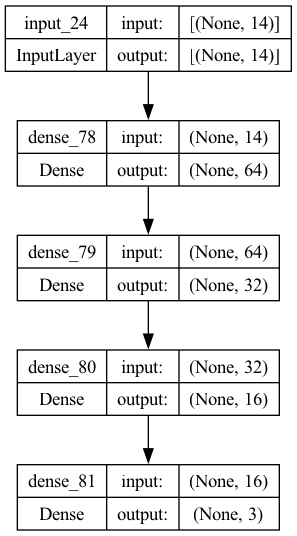

In [267]:
tf.keras.utils.plot_model(model_num, "num_model.png", show_shapes=True)


## 6.3 Model Evaluation

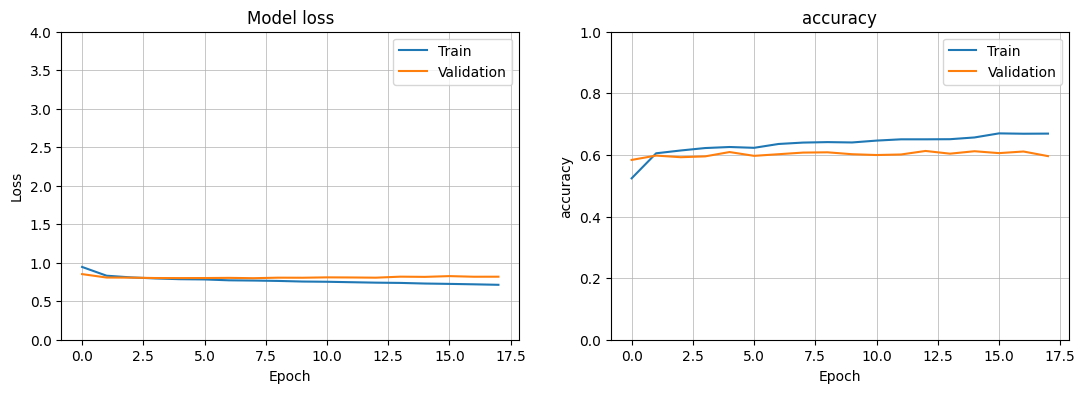

In [268]:
plot_history(history)


In [269]:
loss, accuracy = model_num.evaluate(X_test_num, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 0s 614us/step - loss: 0.7800 - accuracy: 0.6116
Test loss: 0.7800
Test accuracy: 0.6116


30/30 [==============================] - 0s 490us/step


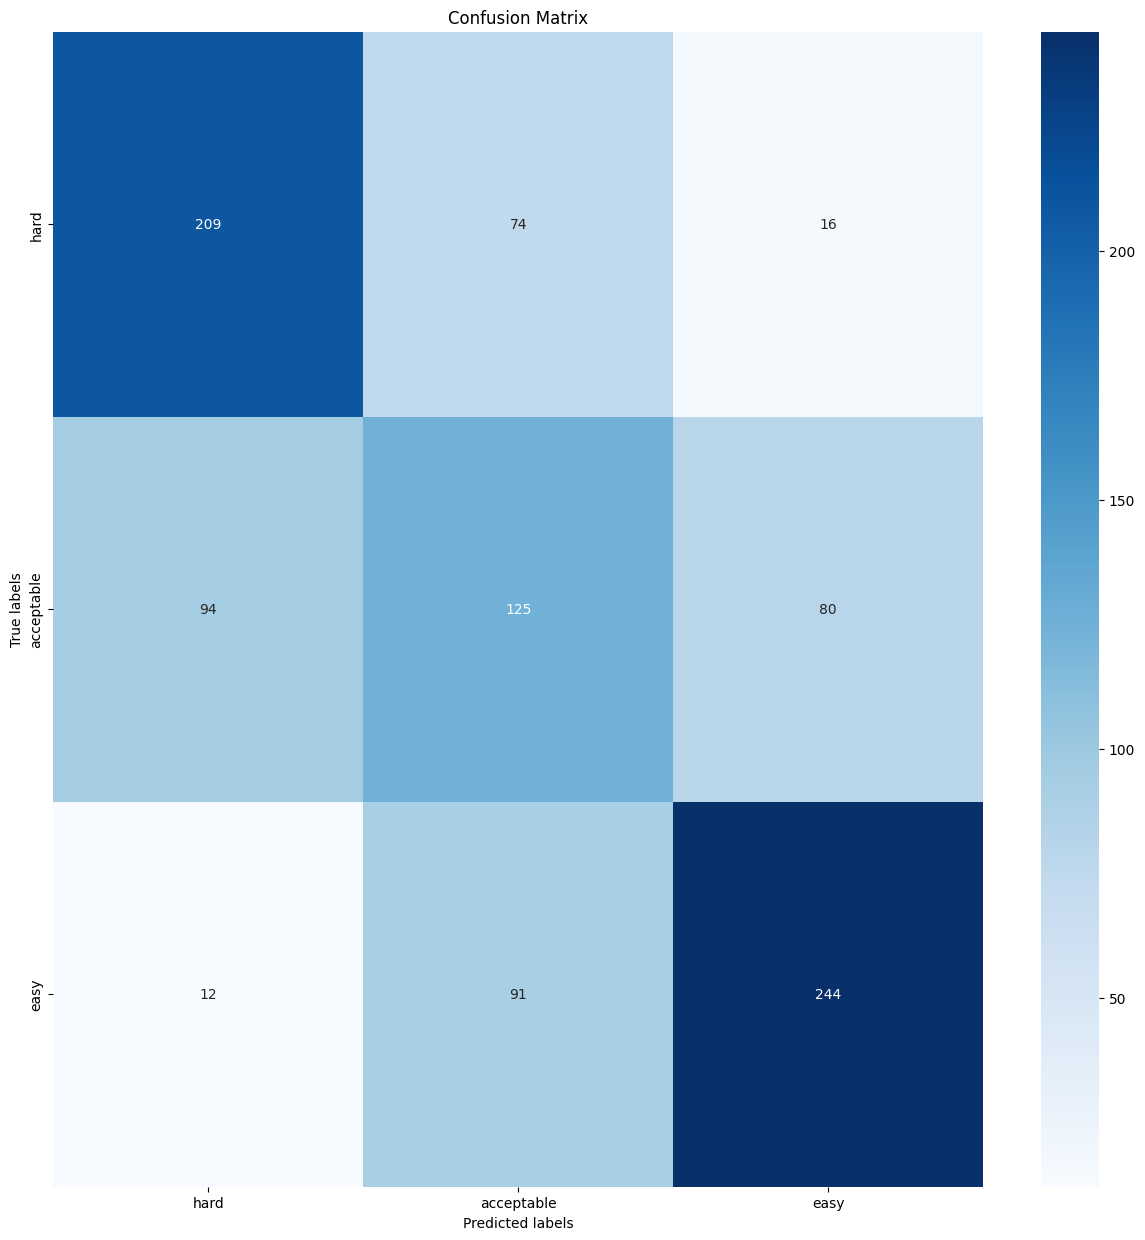

In [270]:
predictions = model_num.predict(X_test_num)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)

y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 7. Combining the models

In [271]:
# Define Inputs and Outputs of NLP model as with Numeric Model
model_nlp = build_model_nlp() # comment-out to keep pre-trained weights not to start from scratch
input_text = model_nlp.input
output_text = model_nlp.output

model_num = build_model_num() # comment-out to keep pre-trained weights not to start from scratch
input_num = model_num.input
output_num = model_num.output


In [272]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_text, input_num]

combined = layers.concatenate([0.8*output_text, 0.2*output_num])

x = layers.Dense(32, activation="relu")(combined)
x = layers.Dropout(0.25)(x)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(3, activation="softmax")(x)

model_combined = models.Model(inputs=inputs, outputs=outputs)


In [273]:
model_combined.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model_combined.fit(x=[X_train_text, X_train_num],
                   y=y_train,
                   validation_split=0.3,
                   epochs=100,
                   batch_size=32,
                   callbacks=[es])


Epoch 1/100
83/83 [==============================] - 16s 148ms/step - loss: 3.9254 - accuracy: 0.4711 - val_loss: 1.9906 - val_accuracy: 0.5670
Epoch 2/100
83/83 [==============================] - 11s 137ms/step - loss: 1.5965 - accuracy: 0.5796 - val_loss: 1.2535 - val_accuracy: 0.6032
Epoch 3/100
83/83 [==============================] - 11s 138ms/step - loss: 1.1173 - accuracy: 0.6015 - val_loss: 0.9531 - val_accuracy: 0.6252
Epoch 4/100
83/83 [==============================] - 11s 137ms/step - loss: 0.9479 - accuracy: 0.6151 - val_loss: 0.8821 - val_accuracy: 0.5935
Epoch 5/100
83/83 [==============================] - 11s 134ms/step - loss: 0.8438 - accuracy: 0.6189 - val_loss: 0.8161 - val_accuracy: 0.6129
Epoch 6/100
83/83 [==============================] - 11s 136ms/step - loss: 0.8169 - accuracy: 0.6125 - val_loss: 0.8043 - val_accuracy: 0.6190
Epoch 7/100
83/83 [==============================] - 11s 136ms/step - loss: 0.8152 - accuracy: 0.6136 - val_loss: 0.7992 - val_accuracy:

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


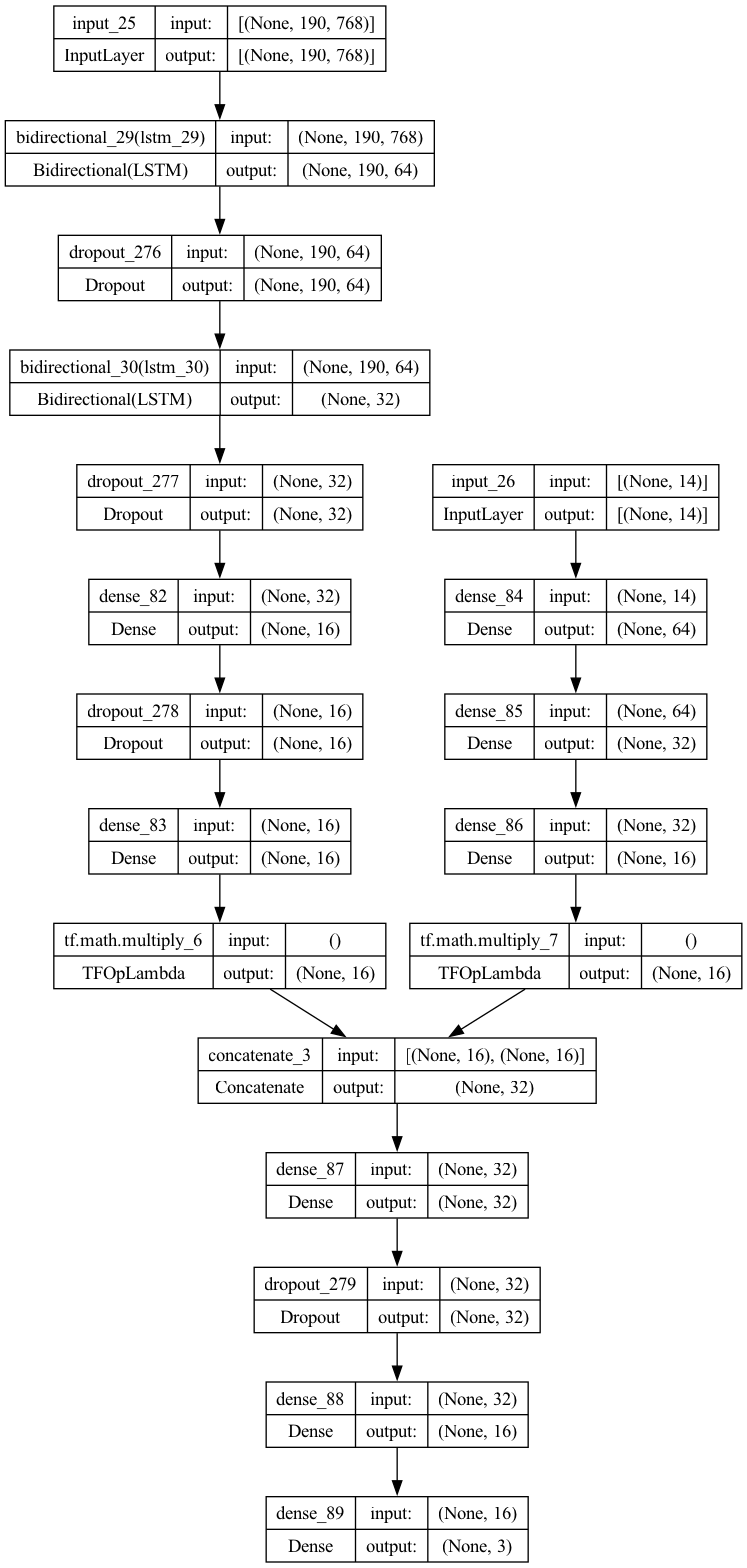

In [274]:
tf.keras.utils.plot_model(model_combined, "combined_last.png", show_shapes=True)


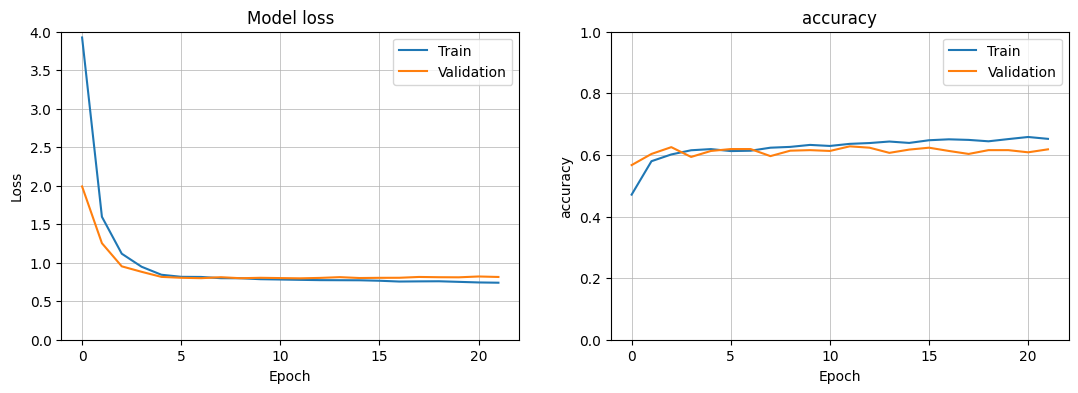

In [275]:
plot_history(history)


In [276]:
loss, accuracy = model_combined.evaluate([X_test_text, X_test_num], y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 45ms/step - loss: 0.7909 - accuracy: 0.6138
Test loss: 0.7909
Test accuracy: 0.6138


In [277]:
predictions = model_combined.predict([X_test_text, X_test_num])

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 2s 45ms/step


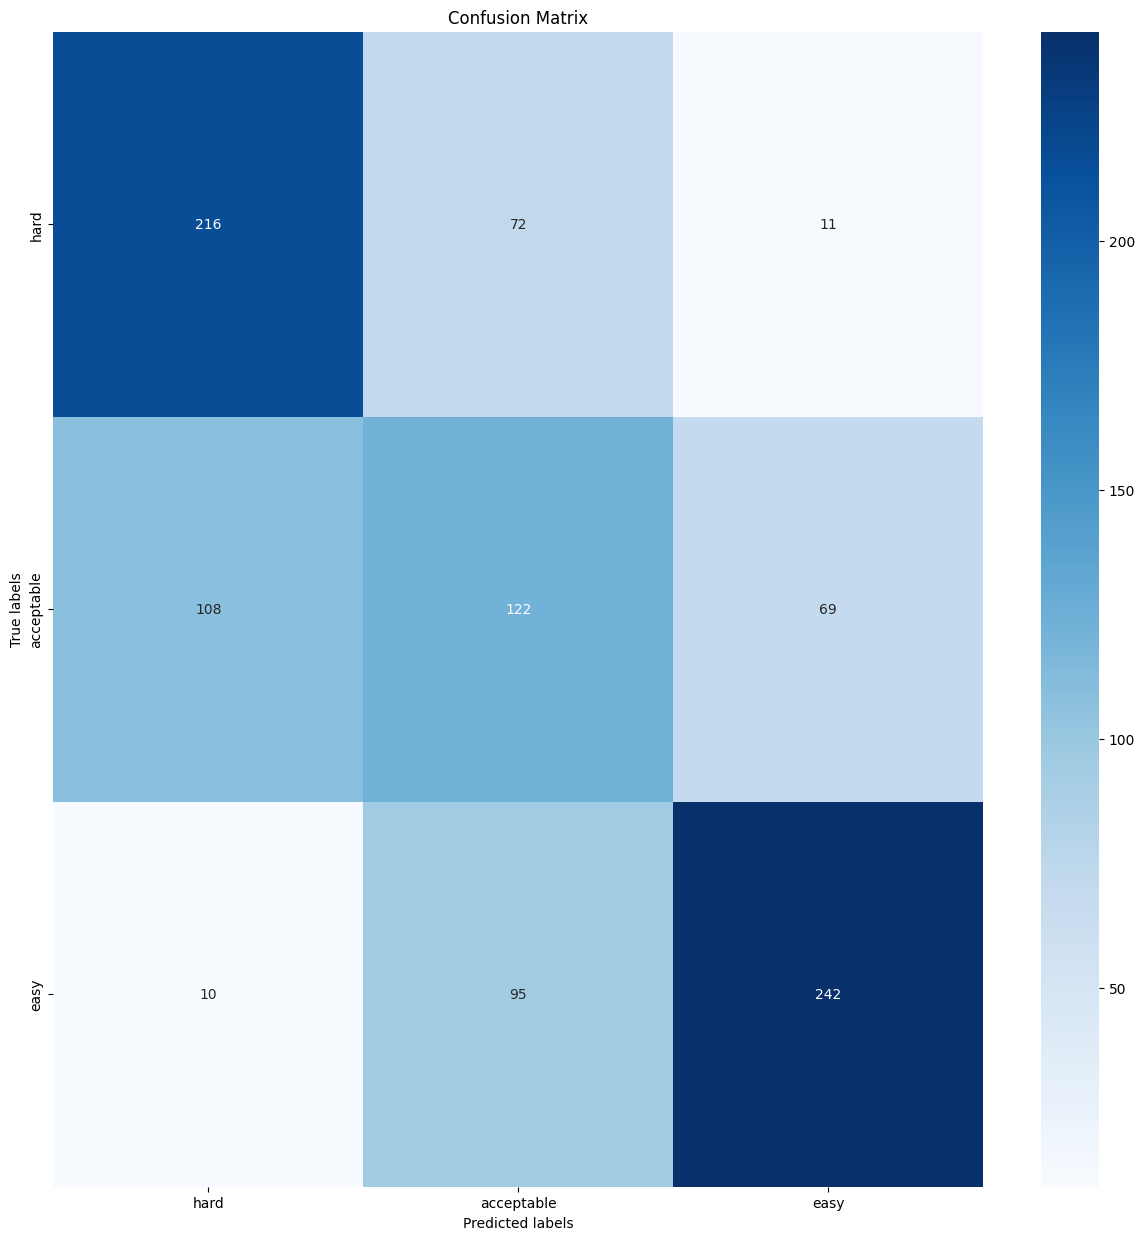

In [278]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


In [279]:
df.columns


Index(['Excerpt', 'BT Easiness', 'New Dale-Chall Readability Formula',
       'CAREC_M', 'CML2RI', 'Avg Word Count', 'Unique Word Count',
       'Avg Word Length', 'punctuation_ratio', 'Avg Characters per Sentence',
       'Capital Char Count', 'Ratio_capital_words', 'Word Length Std',
       'Sentence Length Variation', 'cttr', 'yule_k'],
      dtype='object')

# 8. Trying XGBoost Approach

In [280]:
from xgboost import XGBClassifier


In [281]:
X_test_num, X_val_num, y_test, y_val = train_test_split(
    X_test_num, y_test, test_size = 0.5, random_state = 42  # TEST = 15%
)


In [282]:
xgb_class = XGBClassifier(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.05,
    min_child_weight=1,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    eval_metric=['mlogloss', 'merror']
)

xgb_class.fit(
    X_train_num, y_train,
    eval_set=[(X_train_num, y_train), (X_val_num, y_val)],
    early_stopping_rounds=10
)

# y_pred = xgb_class.predict(X_val_num)

# To get the best iteration accuracy from the training history
results = xgb_class.evals_result()
print("Training mclogloss:", results['validation_0']['mlogloss'][-1])
print("Validation mclogloss:", results['validation_1']['mlogloss'][-1])
print("Training error rate:", results['validation_0']['merror'][-1])
print("Validation error rate:", results['validation_1']['merror'][-1])

# Evaluate and print the accuracy on the validation set
accuracy = xgb_class.score(X_val_num, y_val)
print("Validation accuracy: {:.2f}%".format(accuracy * 100))


[0]	validation_0-mlogloss:1.07739	validation_0-merror:0.35221	validation_1-mlogloss:1.08048	validation_1-merror:0.40803
[1]	validation_0-mlogloss:1.05774	validation_0-merror:0.34850	validation_1-mlogloss:1.06408	validation_1-merror:0.41438
[2]	validation_0-mlogloss:1.03937	validation_0-merror:0.34559	validation_1-mlogloss:1.04877	validation_1-merror:0.41860
[3]	validation_0-mlogloss:1.02189	validation_0-merror:0.34215	validation_1-mlogloss:1.03437	validation_1-merror:0.41860
[4]	validation_0-mlogloss:1.00588	validation_0-merror:0.33951	validation_1-mlogloss:1.02084	validation_1-merror:0.40803
[5]	validation_0-mlogloss:0.99051	validation_0-merror:0.33474	validation_1-mlogloss:1.00863	validation_1-merror:0.42072
[6]	validation_0-mlogloss:0.97629	validation_0-merror:0.33448	validation_1-mlogloss:0.99727	validation_1-merror:0.40803
[7]	validation_0-mlogloss:0.96307	validation_0-merror:0.33342	validation_1-mlogloss:0.98677	validation_1-merror:0.40592
[8]	validation_0-mlogloss:0.95071	valida

/Users/andreacalcagni/.pyenv/versions/3.10.6/envs/neuroCraft/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-mlogloss:0.73277	validation_0-merror:0.28076	validation_1-mlogloss:0.83928	validation_1-merror:0.38266
[43]	validation_0-mlogloss:0.72962	validation_0-merror:0.28050	validation_1-mlogloss:0.83765	validation_1-merror:0.38055
[44]	validation_0-mlogloss:0.72624	validation_0-merror:0.28076	validation_1-mlogloss:0.83612	validation_1-merror:0.38478
[45]	validation_0-mlogloss:0.72339	validation_0-merror:0.27891	validation_1-mlogloss:0.83449	validation_1-merror:0.38266
[46]	validation_0-mlogloss:0.72016	validation_0-merror:0.27865	validation_1-mlogloss:0.83322	validation_1-merror:0.38901
[47]	validation_0-mlogloss:0.71699	validation_0-merror:0.27759	validation_1-mlogloss:0.83190	validation_1-merror:0.39112
[48]	validation_0-mlogloss:0.71421	validation_0-merror:0.27679	validation_1-mlogloss:0.83054	validation_1-merror:0.38901
[49]	validation_0-mlogloss:0.71149	validation_0-merror:0.27468	validation_1-mlogloss:0.82888	validation_1-merror:0.38689
[50]	validation_0-mlogloss:0.708

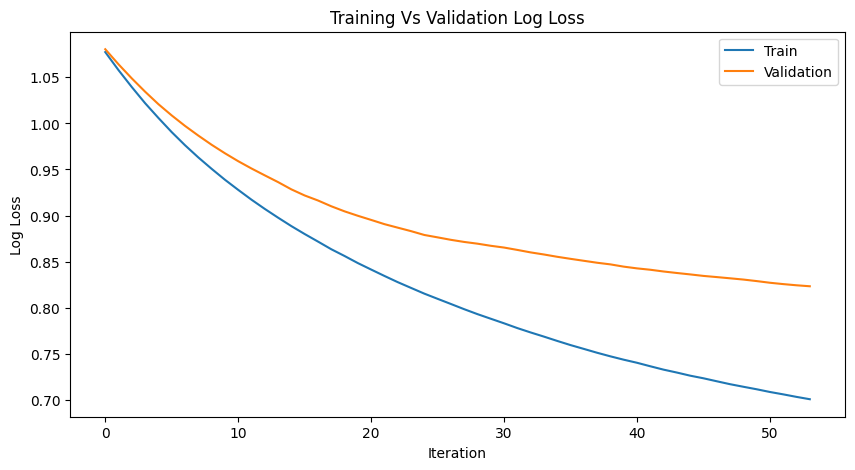

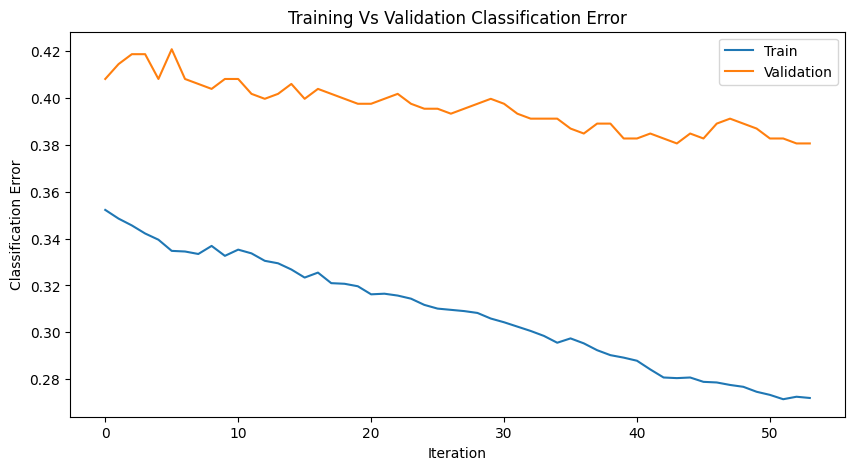

In [283]:
# Get evaluation results
evals_result = xgb_class.evals_result()

# Plot training & validation log loss metrics
train_errors = evals_result['validation_0']['mlogloss']
val_errors = evals_result['validation_1']['mlogloss']

plt.figure(figsize=(10,5))
plt.plot(train_errors, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training Vs Validation Log Loss')
plt.legend()
plt.show()

# Plot training & validation error metrics
train_merrors = evals_result['validation_0']['merror']
val_merrors = evals_result['validation_1']['merror']

plt.figure(figsize=(10,5))
plt.plot(train_merrors, label='Train')
plt.plot(val_merrors, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Classification Error')
plt.title('Training Vs Validation Classification Error')
plt.legend()
plt.show()


## 8.1 Permutation

In [284]:
from sklearn.model_selection import cross_val_score

# Model to be cross-validated

# Cross Validation
np.mean(cross_val_score(xgb_class, X_train_num, y_train, cv=5, scoring='accuracy'))


0.5972441220785591

In [285]:
X_train_features = X_train.drop(columns=['Excerpt']).columns
X_train_features


Index(['New Dale-Chall Readability Formula', 'CAREC_M', 'CML2RI',
       'Avg Word Count', 'Unique Word Count', 'Avg Word Length',
       'punctuation_ratio', 'Avg Characters per Sentence',
       'Capital Char Count', 'Ratio_capital_words', 'Word Length Std',
       'Sentence Length Variation', 'cttr', 'yule_k'],
      dtype='object')

In [286]:
# Assuming you have a list of feature names as 'feature_names'
from sklearn.inspection import permutation_importance
feature_names = X_train_features  # replace with your actual feature names

# Calculate permutation importance
permutation_score = permutation_importance(xgb_class, X_train_num, y_train, n_repeats=10)

# Create a DataFrame for the importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'score decrease': permutation_score.importances_mean
})

# Show the important features
importance_df.sort_values(by="score decrease", ascending=False, inplace=True)


In [287]:
importance_df


,feature,score decrease
0,New Dale-Chall Readability Formula,0.142286
1,CAREC_M,0.092961
2,CML2RI,0.064726
11,Sentence Length Variation,0.045912
5,Avg Word Length,0.034983
12,cttr,0.023313
3,Avg Word Count,0.021064
9,Ratio_capital_words,0.017306
10,Word Length Std,0.015480
7,Avg Characters per Sentence,0.014289


In [288]:
columns_to_drop = importance_df[importance_df['score decrease'] < 0.016]['feature'].values
columns_to_drop


array(['Word Length Std', 'Avg Characters per Sentence',
       'Capital Char Count', 'yule_k', 'Unique Word Count',
       'punctuation_ratio'], dtype=object)

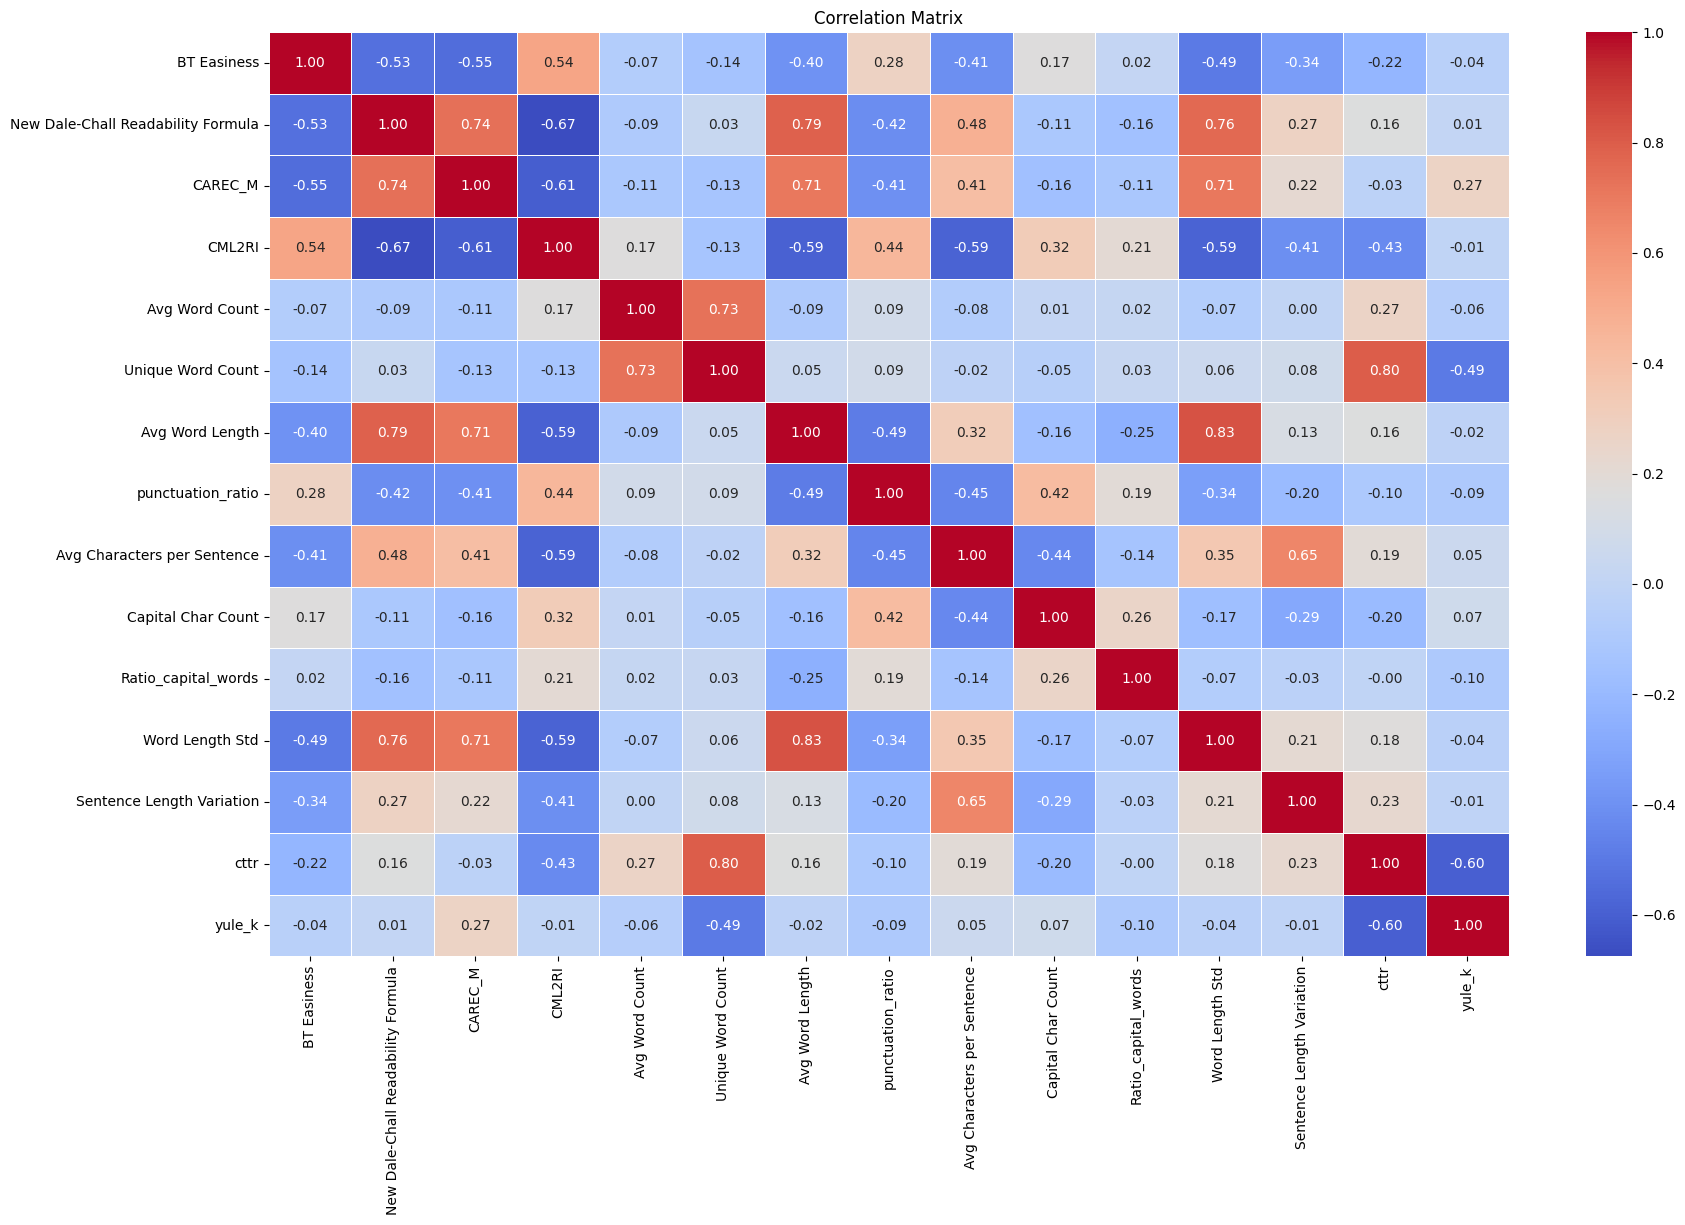

In [289]:
df_columns = df.columns
df_num = df.drop(columns=["Excerpt"])

# Calculate the correlation matrix
correlation_matrix = df_num.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
